# Exploring the Factors Linked to Heart Disease in the U.S. during 2020

*Project Author: Liangjie Lu, Sara Abril Guevara, Dhriti Raval, and Prakriti Sarkar*

*Code Author: Liangjie Lu, Sara Abril Guevara*

## Data Source

https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/

## Import Data

In [1]:
import pandas as pd

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 50)

# Load the dataset
heart_data = pd.read_csv("heart_2020_cleaned.csv")

# Display the first few rows of the dataset
heart_data.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Let's start by loading the data and taking a quick look at the first few rows to understand its structure.

The dataset consists of various columns related to heart health and associated risk factors. Here's a brief overview of the columns:

1. **HeartDisease**: Indicates if the individual has heart disease (Yes/No).
2. **BMI**: Body Mass Index of the individual.
3. **Smoking**: Indicates if the individual smokes (Yes/No).
4. **AlcoholDrinking**: Indicates if the individual drinks alcohol (Yes/No).
5. **Stroke**: Indicates if the individual has had a stroke (Yes/No).
6. **PhysicalHealth**: Number of days physical health was not good in the last month.
7. **MentalHealth**: Number of days mental health was not good in the last month.
8. **DiffWalking**: Indicates if the individual has difficulty walking (Yes/No).
9. **Sex**: Gender of the individual (Male/Female).
10. **AgeCategory**: Age category of the individual.
11. **Race**: Race of the individual.
12. **Diabetic**: Indicates if the individual is diabetic, but an ordinal variable indeed (No | Yes(during pregnancy) | No, borderline diabetes | Yes).
13. **PhysicalActivity**: Indicates if the individual engages in physical activity (Yes/No).
14. **GenHealth**: General health perception (Excellent Very good, Good, Fair, Poor).
15. **SleepTime**: Number of hours the individual sleeps on average.
16. **Asthma**: Indicates if the individual has asthma (Yes/No).
17. **KidneyDisease**: Indicates if the individual has kidney disease (Yes/No).
18. **SkinCancer**: Indicates if the individual has had skin cancer (Yes/No).

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separate the categorical and numerical columns
categorical_cols = heart_data.select_dtypes(include=["object"]).columns
numerical_cols = heart_data.select_dtypes(exclude=["object"]).columns

# For nominal variables, create dummy variables excluding the ordinal variables
nominal_vars = list(categorical_cols)  # start with all categorical columns
ordinal_vars = ['AgeCategory', 'GenHealth', 'Diabetic']  # list of ordinal columns
# Remove ordinal columns from the list of nominal columns
nominal_vars = [var for var in nominal_vars if var not in ordinal_vars]

nominal_more_than_two = [var for var in nominal_vars if heart_data[var].nunique() > 2]

# For variables with only two categories, we can encode them directly into binary
binary_nominal_vars = [var for var in nominal_vars if heart_data[var].nunique() == 2]

# Update the nominal variables list to exclude the binary nominal variables
nominal_vars = [var for var in nominal_vars if var not in binary_nominal_vars]

# Use get_dummies for nominal variables with more than two categories
heart_data = pd.get_dummies(heart_data, columns=nominal_vars, drop_first=True)

# Directly map binary nominal variables to 0 and 1, and keep their original names
for binary_var in binary_nominal_vars:
    # Find the categories
    categories = heart_data[binary_var].unique()
    # Map the first category to 0 and the second to 1
    if categories[0] in ['No', 'Yes']:
        categories = ['No', 'Yes']
    elif categories[0] in ['Female', 'Male']:
        categories = ['Female', 'Male']
    heart_data[binary_var] = heart_data[binary_var].map({categories[0]: 0, categories[1]: 1})


# Now encode the ordinal variables. We'll create a mapping for each.
# Assuming the AgeCategory column is sorted in ascending order of age and GenHealth in order of health
# Adjust the mappings as per the correct order if needed.
age_mapping = {'18-24': 0,
               '25-29': 1, 
               '30-34': 2, 
               '35-39': 3, 
               '40-44': 4, 
               '45-49': 5, 
               '50-54': 6,  
               '55-59': 7,
               '60-64': 8, 
               '65-69': 9, 
               '70-74': 10,
               '75-79': 11, 
               '80 or older': 12}
gen_health_mapping = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4}
diabetic_mapping = {'No': 0, 'Yes (during pregnancy)': 1, 
                    'No, borderline diabetes': 2, 'Yes': 3} # In my opinion, Yes(DP) is less serious than No(BD)


# Apply the mappings to the ordinal columns
heart_data['AgeCategory'] = heart_data['AgeCategory'].map(age_mapping)
heart_data['GenHealth'] = heart_data['GenHealth'].map(gen_health_mapping)
heart_data['Diabetic'] = heart_data['Diabetic'].map(diabetic_mapping)


To investigate the linear, non-linear, and interaction effects of these variables, I will start by:

1. Encoding categorical variables.
2. Creating polynomial features (for potential non-linear relationships).
3. Creating interaction terms.

But first, let's conduct some basic exploratory data analysis (EDA) to understand the distribution of some of these variables.

## Exploratory Data Analysis(EDA)

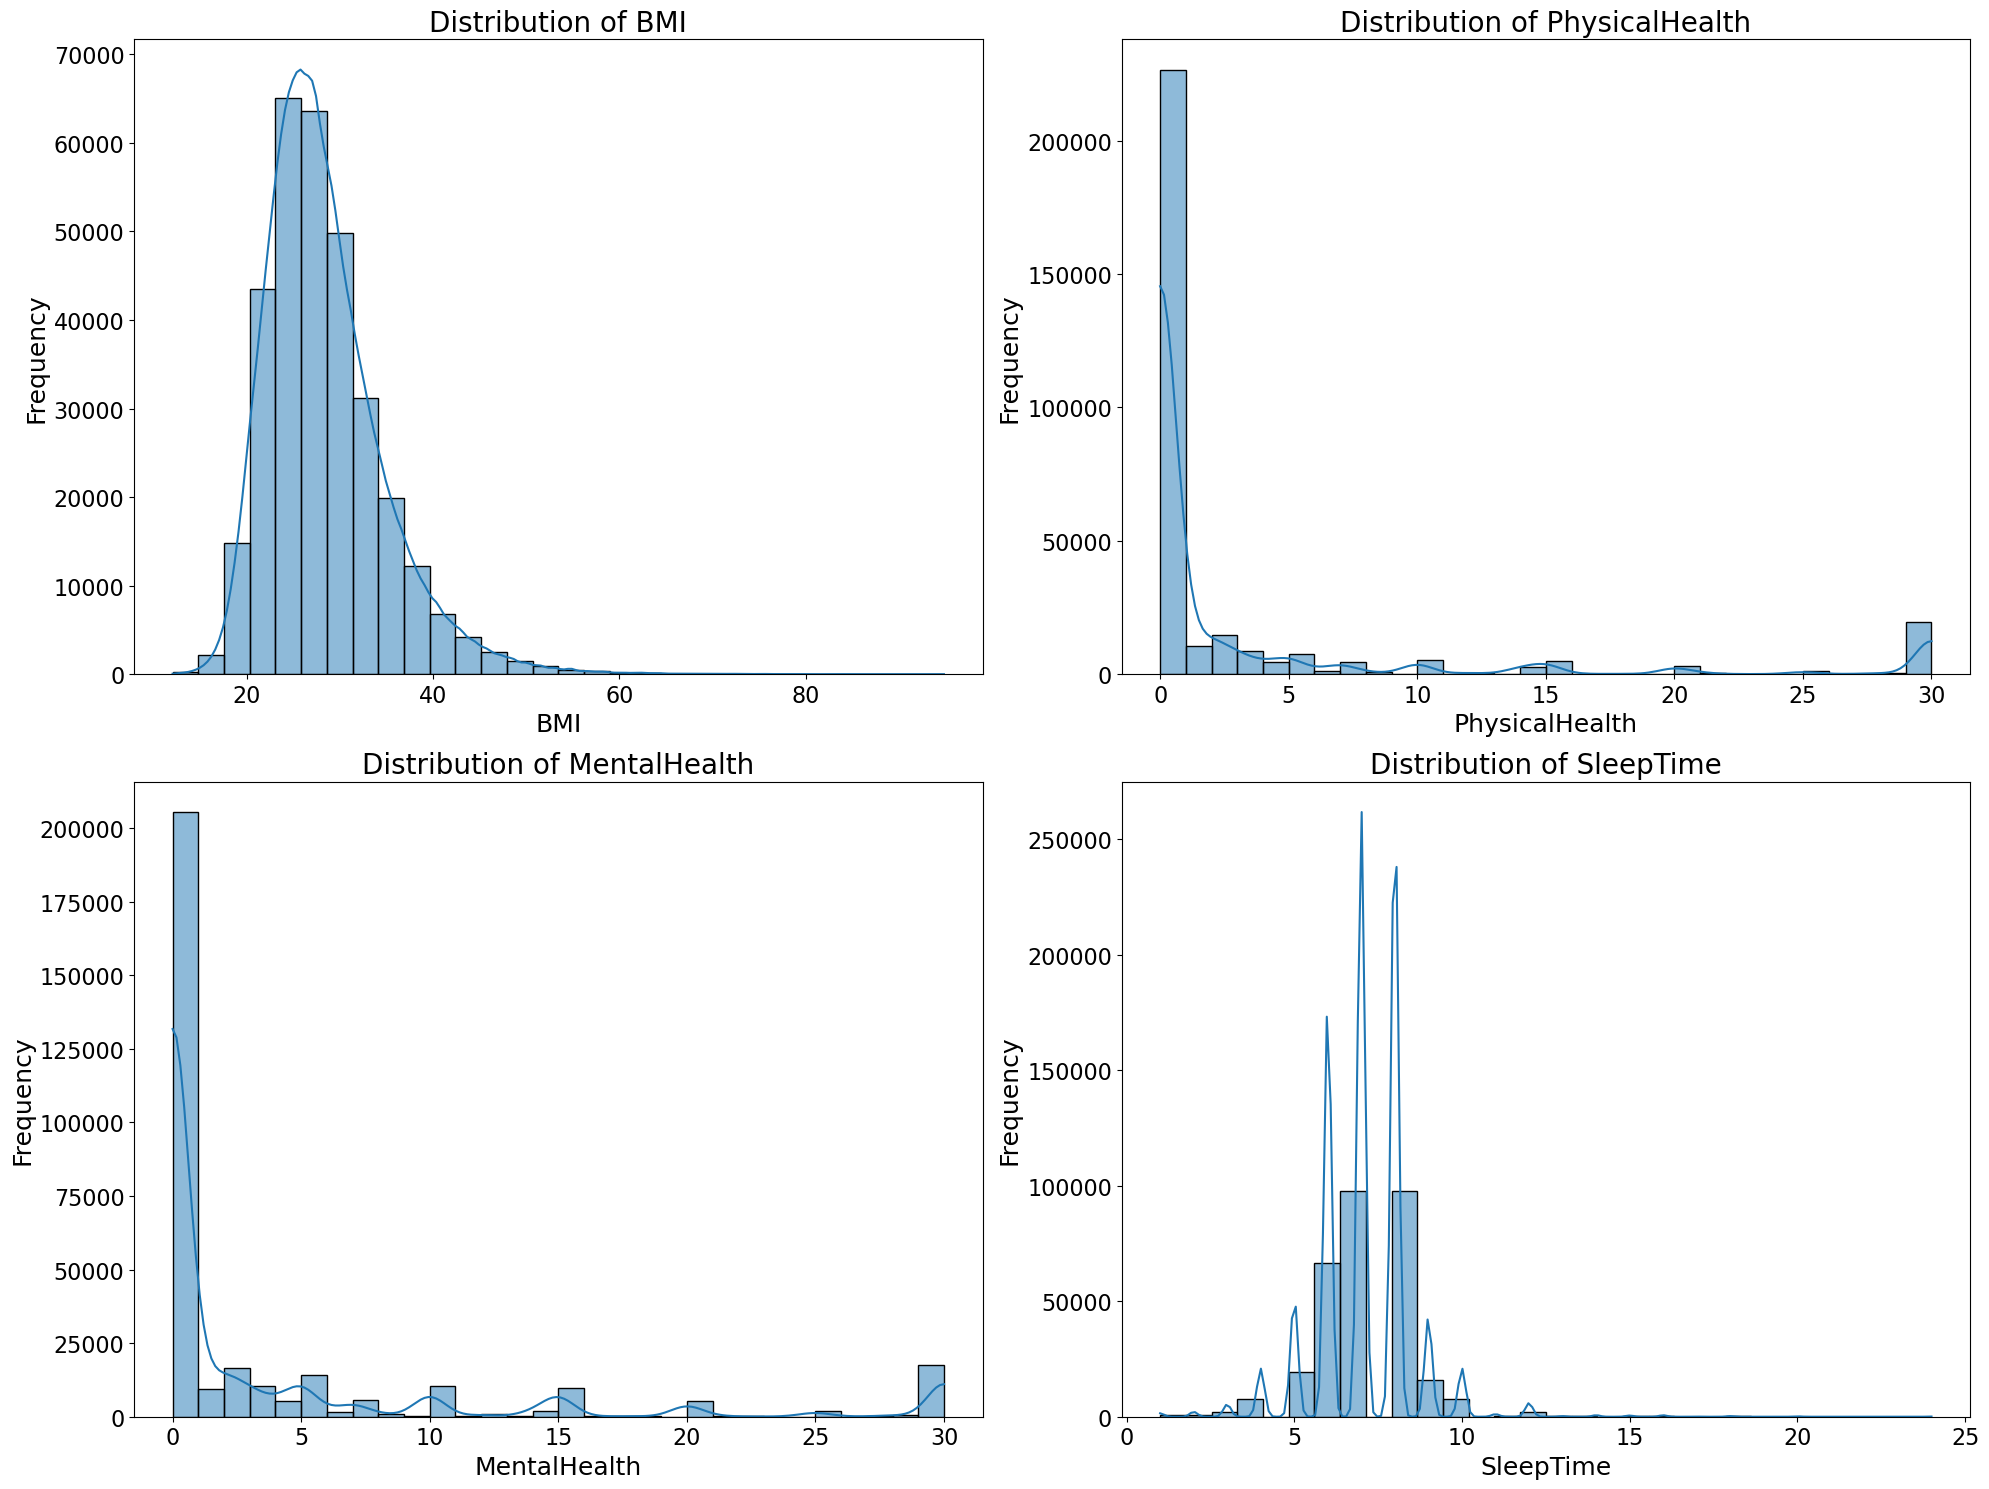

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase font sizes
plt.rcParams['axes.titlesize'] = 20  # Set the size for titles
plt.rcParams['axes.labelsize'] = 18  # Set the size for x and y labels
plt.rcParams['xtick.labelsize'] = 16  # Set the size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Set the size for y-axis tick labels

# Set up the figure size
plt.figure(figsize=(20, 15))

# Plot the distribution of a few key columns. We only have 4 columns containing continuous variables
cols_to_plot = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(heart_data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


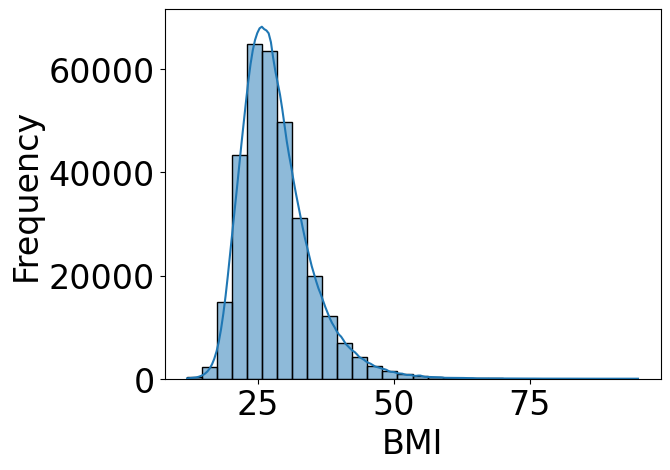

In [109]:
sns.histplot(heart_data['BMI'], bins=30, kde=True)
# plt.title('Distribution of BMI')
plt.xlabel('BMI', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('BMI_distribution.png', bbox_inches='tight')
plt.show()

Here are the distributions of some key numerical variables:

1. **BMI (Body Mass Index)**: The distribution seems to be slightly right-skewed, with the majority of individuals having a BMI in the range of 20-30.
2. **PhysicalHealth**: This variable shows the number of days in the last month where physical health was not good. Most individuals reported 0 days, but there's a long tail indicating some individuals experienced many days of poor physical health.
3. **MentalHealth**: Similar to "PhysicalHealth", most individuals reported 0 days of poor mental health in the last month, but there's also a long tail indicating some individuals experienced many days of poor mental health.
4. **SleepTime**: Most individuals reported sleeping between 6 to 8 hours, which is within the recommended range for adults.

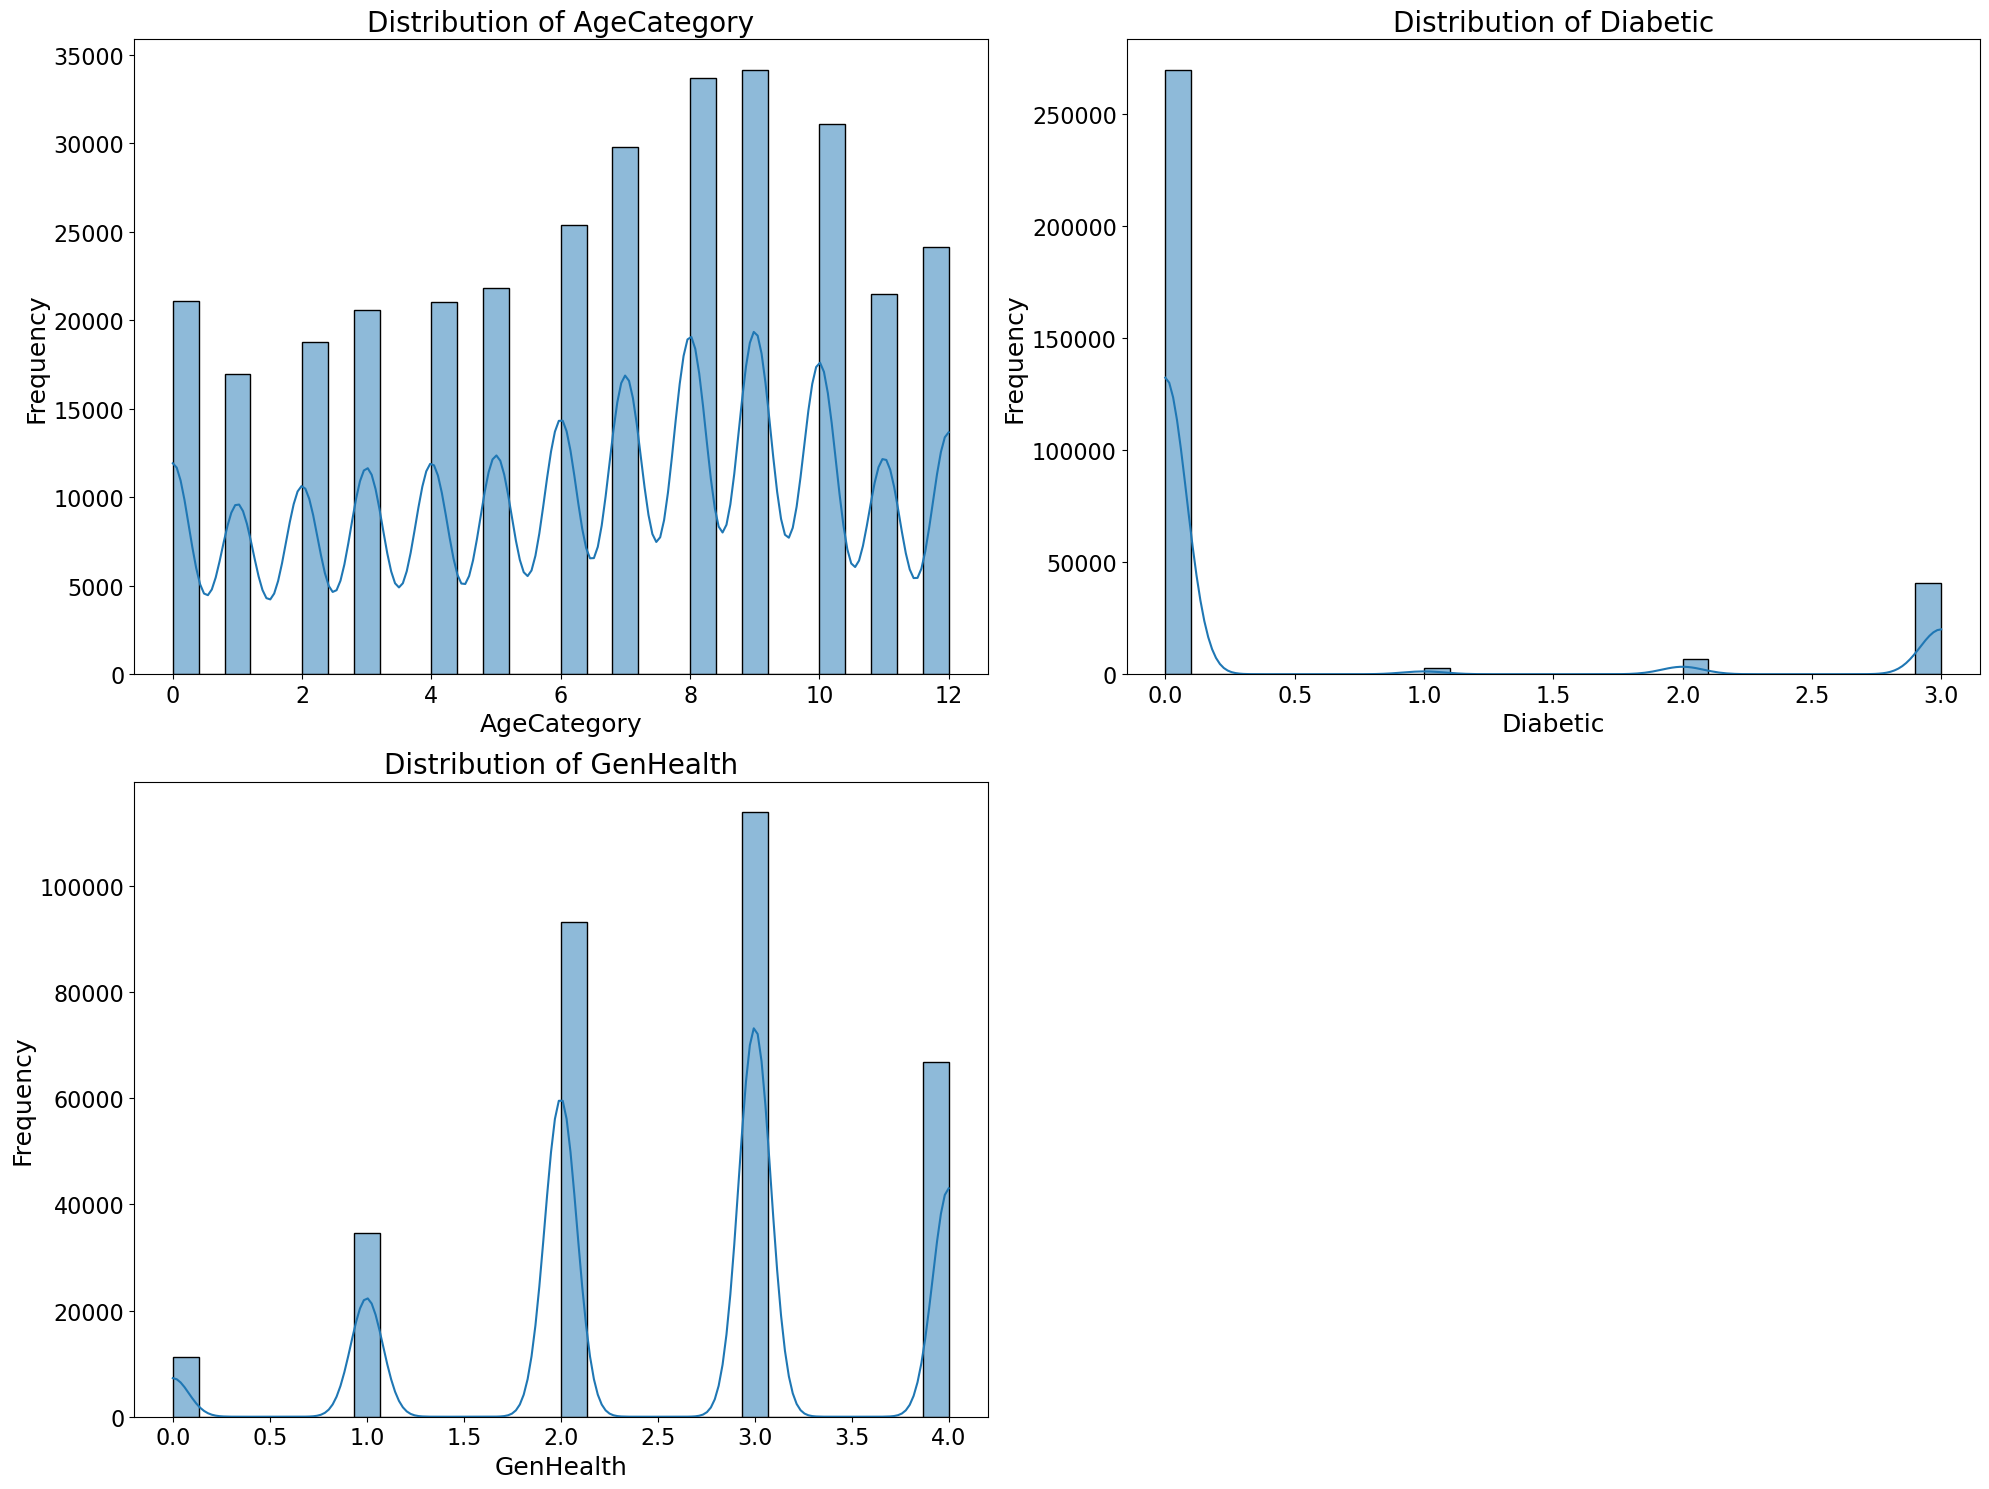

In [5]:
# Set up the figure size
plt.figure(figsize=(20, 15))
# Plot the distribution of a few key columns. We only have 4 columns containing continuous variables
cols_to_plot = ['AgeCategory', 'Diabetic', 'GenHealth']

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(heart_data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

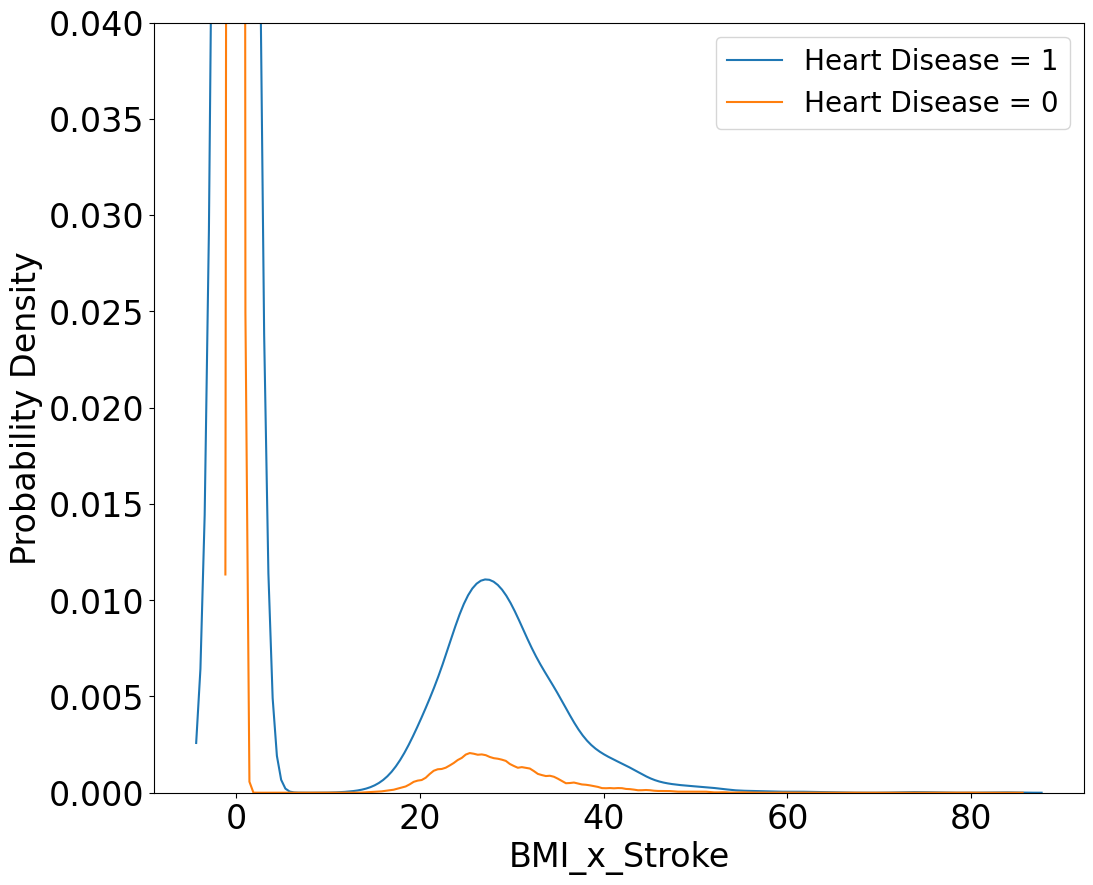

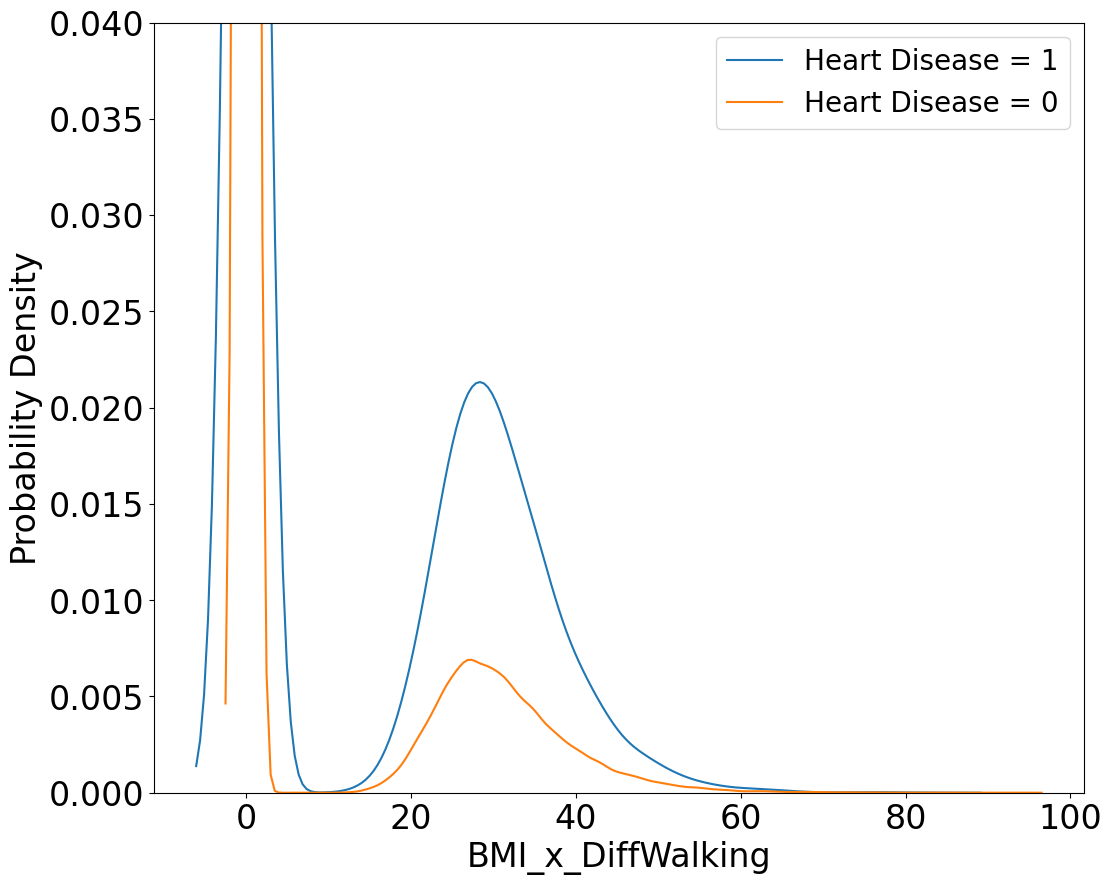

In [111]:
plt.figure(figsize=(12, 10))

# Density plot for HeartDisease == 1
sns.kdeplot(heart_data[heart_data['HeartDisease'] == 1]['BMI_x_Stroke'], label='Heart Disease = 1', shade=False)

# Density plot for HeartDisease == 0
sns.kdeplot(heart_data[heart_data['HeartDisease'] == 0]['BMI_x_Stroke'], label='Heart Disease = 0', shade=False)

plt.ylim(0, 0.04)  # Adjust the y-axis limit as needed
# plt.title('Truncated Probability Density of BMI-Stroke Interaction by Heart Disease Status (Cutoff at 0.04)', fontsize=24)
plt.xlabel('BMI_x_Stroke', fontsize=24)
plt.ylabel('Probability Density', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.legend(fontsize=20)
plt.savefig('BMIxStroke_vs_HeartDisease.png')
plt.figure(figsize=(12, 10))

# Density plot for HeartDisease == 1
sns.kdeplot(heart_data[heart_data['HeartDisease'] == 1]['BMI_x_DiffWalking'], label='Heart Disease = 1', shade=False)

# Density plot for HeartDisease == 0
sns.kdeplot(heart_data[heart_data['HeartDisease'] == 0]['BMI_x_DiffWalking'], label='Heart Disease = 0', shade=False)

plt.ylim(0, 0.04)  # Adjust the y-axis limit as needed
# plt.title('Truncated Probability Density of BMI-Difficulty in Walking Interaction by Heart Disease Status (Cutoff at 0.04)', fontsize=24)
plt.xlabel('BMI_x_DiffWalking', fontsize=24)
plt.ylabel('Probability Density', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.legend(fontsize=20)
plt.savefig('BMIxDiffWalking_vs_HeartDisease.png')


<Figure size 1000x1200 with 0 Axes>

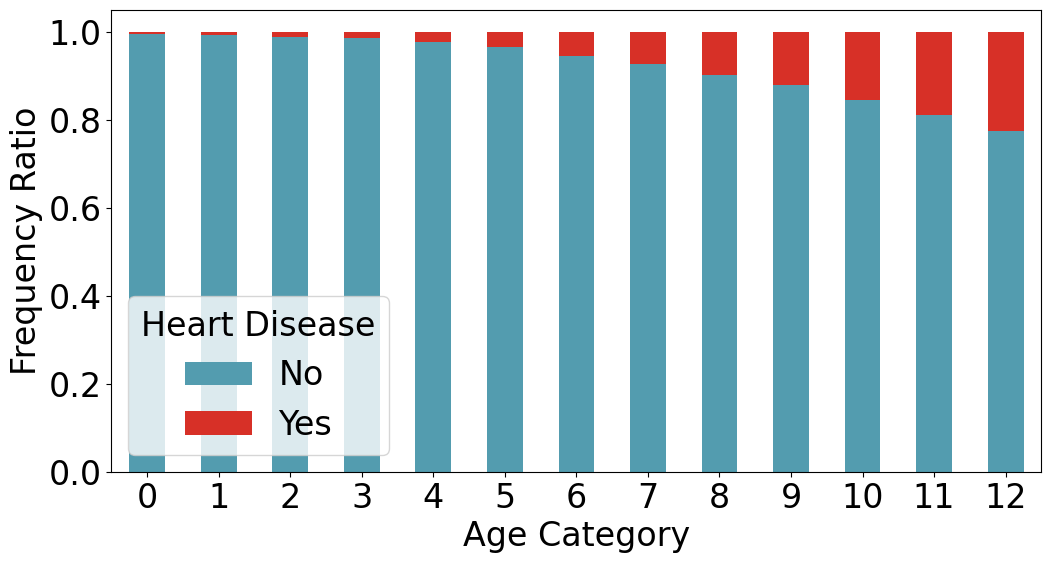

In [98]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['AgeCategory'], heart_data['HeartDisease'], normalize='index')

plt.figure(figsize=(10, 12))
# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('Age Category', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('AgeCategory_distribution.png', bbox_inches='tight')
plt.show()

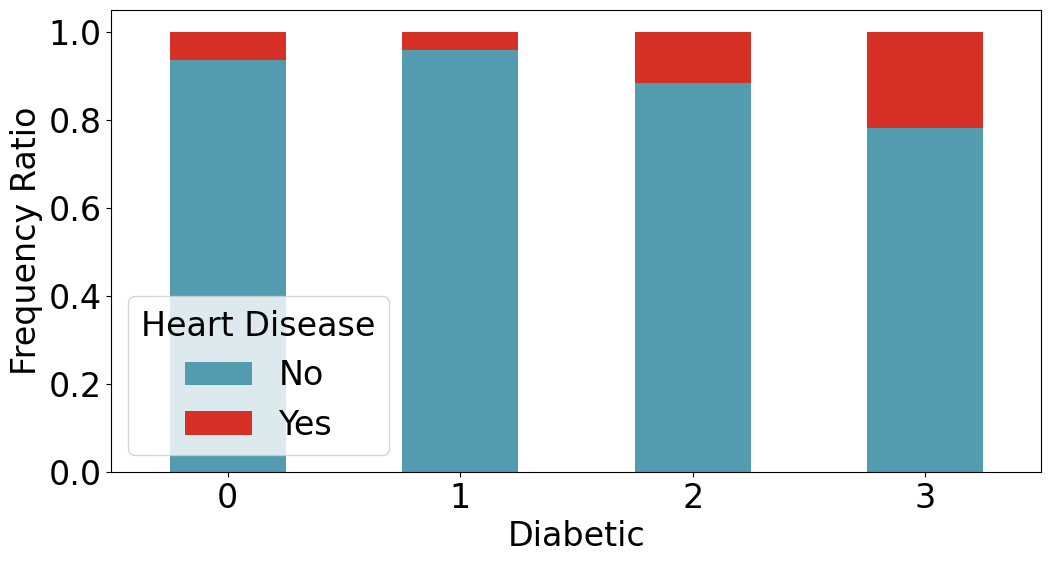

In [101]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['Diabetic'], heart_data['HeartDisease'], normalize='index')

# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('Diabetic', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('Diabetic_distribution.png', bbox_inches='tight')
plt.show()

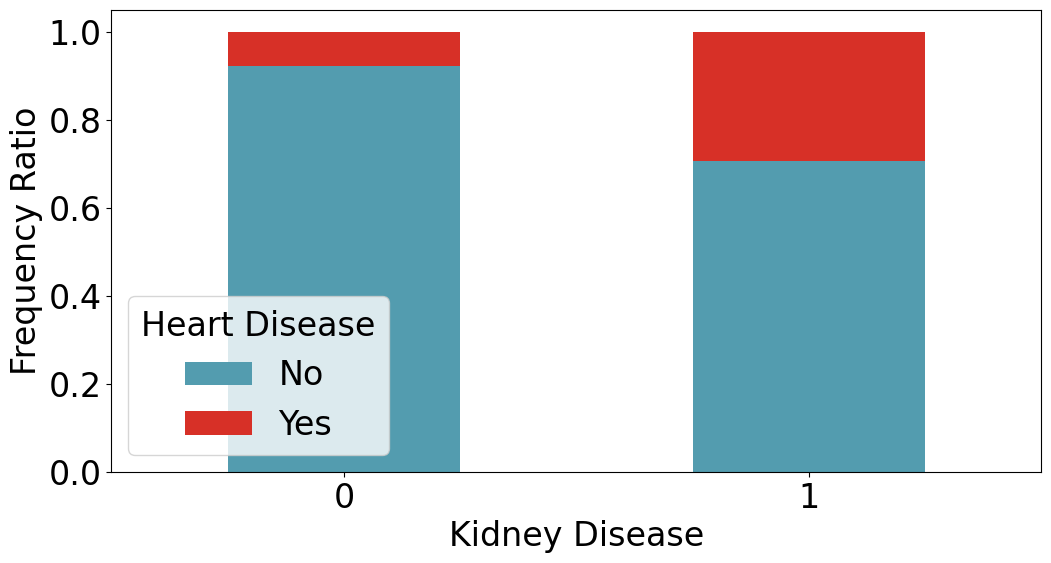

In [102]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['KidneyDisease'], heart_data['HeartDisease'], normalize='index')

# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('Kidney Disease', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('KidneyDisease_distribution.png', bbox_inches='tight')
plt.show()

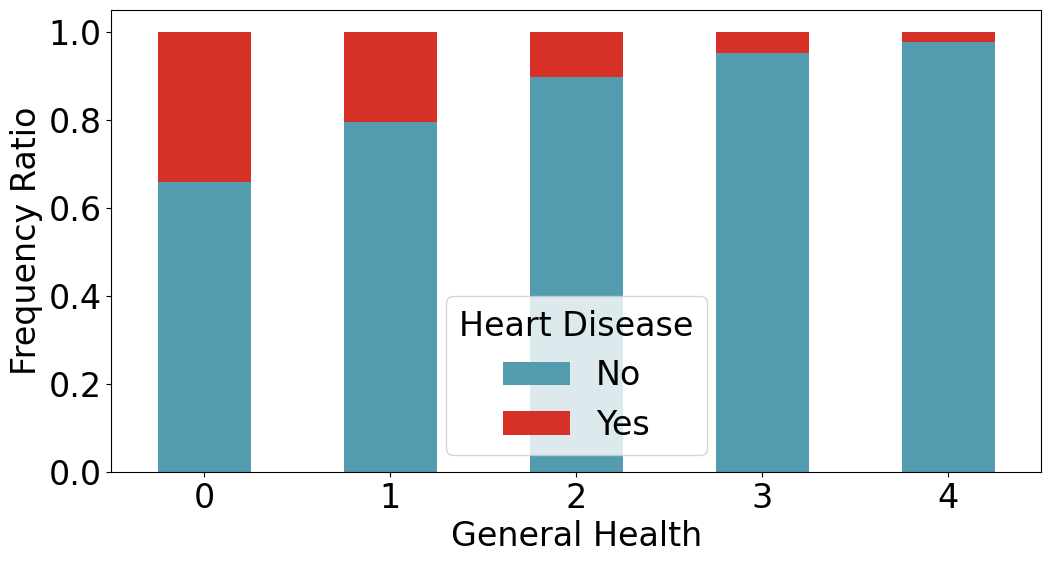

In [103]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['GenHealth'], heart_data['HeartDisease'], normalize='index')

# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('General Health', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('GenHealth_distribution.png', bbox_inches='tight')
plt.show()

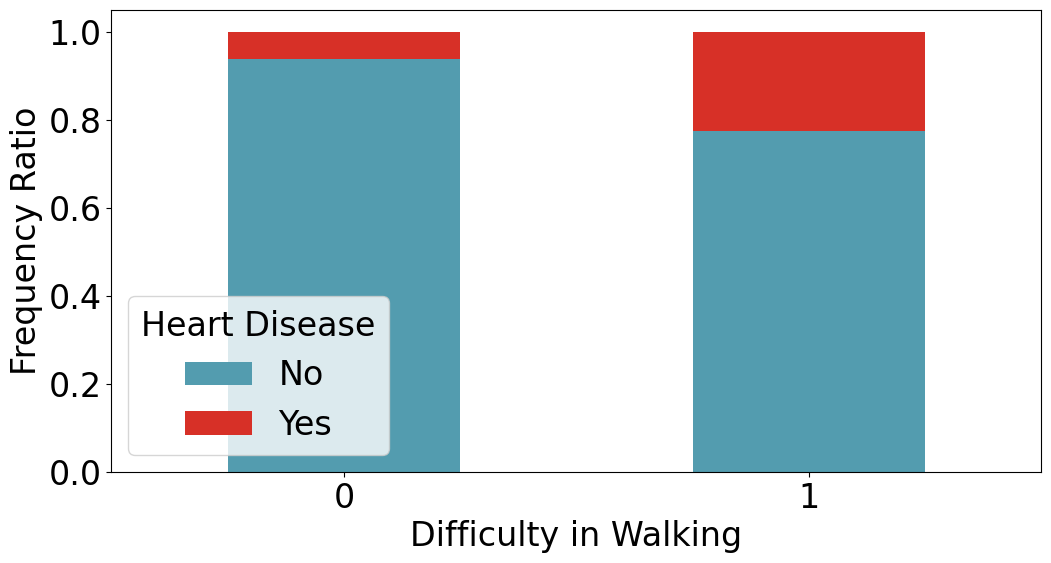

In [104]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['DiffWalking'], heart_data['HeartDisease'], normalize='index')

# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('Difficulty in Walking', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('DiffWalking_Distribution.png', bbox_inches='tight')
plt.show()

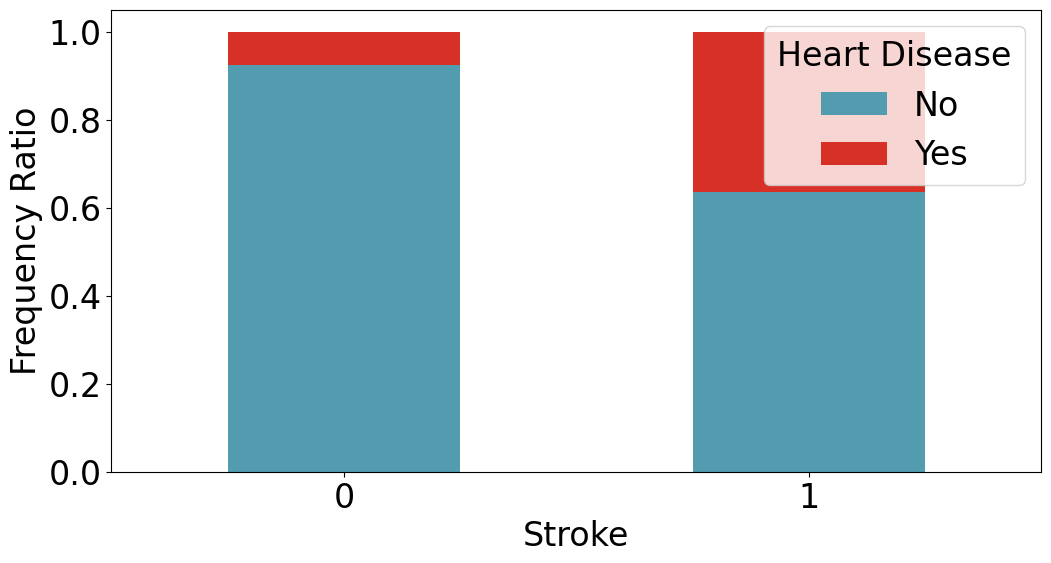

In [105]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['Stroke'], heart_data['HeartDisease'], normalize='index')

# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('Stroke', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('Stroke_distribution.png', bbox_inches='tight')
plt.show()

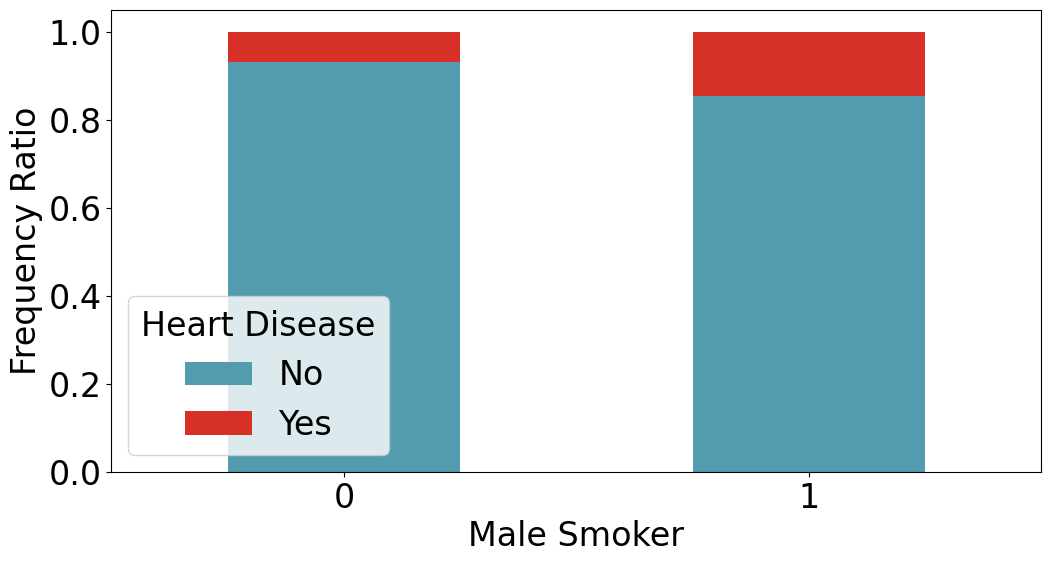

In [106]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['Smoking_x_Sex'], heart_data['HeartDisease'], normalize='index')

# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('Male Smoker', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('Smoking_x_Sex_distribution.png', bbox_inches='tight')
plt.show()

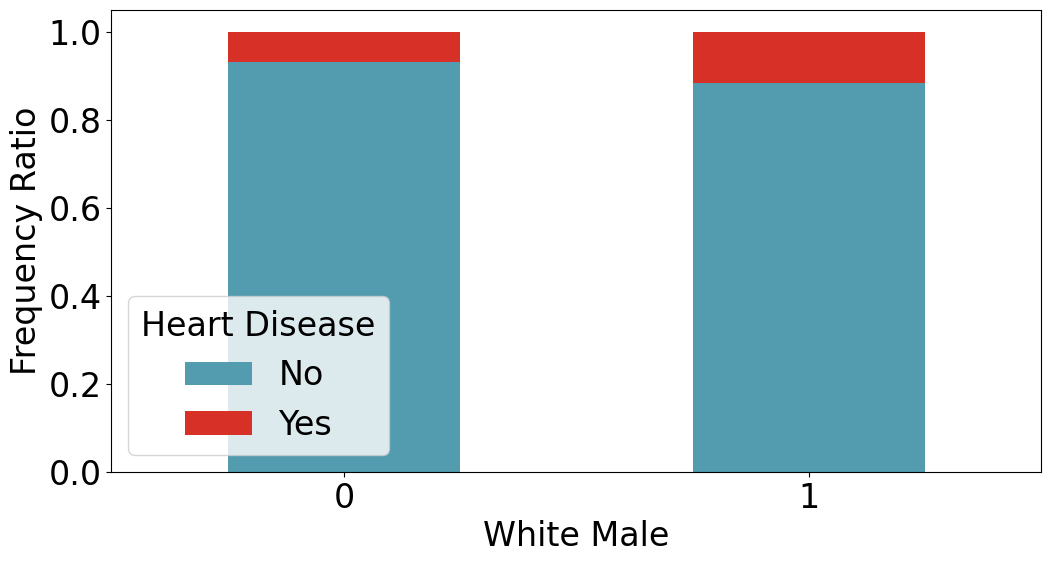

In [107]:
# Calculate frequency ratios
frequency_table = pd.crosstab(heart_data['Sex_x_Race_White'], heart_data['HeartDisease'], normalize='index')

# Plotting
frequency_table.plot(kind='bar', color=["#539caf", "#d73027"], stacked=True, figsize=(12, 6))

# plt.title('Frequency Ratio of Heart Disease in Different Age Categories')
plt.xlabel('White Male', fontsize = 24)
plt.ylabel('Frequency Ratio', fontsize = 24)
plt.legend(title='Heart Disease', labels=['No', 'Yes'], fontsize = 24, title_fontsize=24)
# Making x-axis labels upright
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('Sex_x_Race_White_distribution.png', bbox_inches='tight')
plt.show()

## Creating meaningful second order and interation terms

In [6]:
import numpy as np
# Generate interaction terms
colnames = heart_data.columns
column_to_exclude = ['HeartDisease', 'AgeCategory', 'Diabetic', 'GenHealth']
race_dummy = ['Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White']
for i, col in enumerate(colnames):
    # Create a new DataFrame to store interaction terms
    interaction_df = pd.DataFrame(index=heart_data.index)
    # Add polynominal terms of numeric variables, max order of poly = 2
    if col in numerical_cols:
        interaction_term = col + '^2'
        interaction_df[interaction_term] = heart_data[col]**2
    for j, other_col in enumerate(colnames[i+1:], start=i+1):
        if col in column_to_exclude or other_col in column_to_exclude:
            continue
        if col in race_dummy and other_col in race_dummy:
            continue     # One variable can not interact with itself  | Exclude Y = HeartDisease and Ordinal Variables
        interaction_term = col + '_x_' + other_col
        interaction_df[interaction_term] = heart_data[col] * heart_data[other_col]
    # Concatenate the interaction terms to the original DataFrame
    heart_data = pd.concat([heart_data, interaction_df], axis=1)

## Modeling

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Split the data into features and target
X = heart_data.drop('HeartDisease', axis=1)
y = heart_data['HeartDisease']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,BMI^2,BMI_x_Smoking,BMI_x_AlcoholDrinking,BMI_x_Stroke,BMI_x_PhysicalHealth,BMI_x_MentalHealth,BMI_x_DiffWalking,BMI_x_Sex,BMI_x_PhysicalActivity,BMI_x_SleepTime,BMI_x_Asthma,BMI_x_KidneyDisease,BMI_x_SkinCancer,BMI_x_Race_Asian,BMI_x_Race_Black,BMI_x_Race_Hispanic,BMI_x_Race_Other,BMI_x_Race_White,Smoking_x_AlcoholDrinking,Smoking_x_Stroke,Smoking_x_PhysicalHealth,Smoking_x_MentalHealth,Smoking_x_DiffWalking,Smoking_x_Sex,Smoking_x_PhysicalActivity,Smoking_x_SleepTime,Smoking_x_Asthma,Smoking_x_KidneyDisease,Smoking_x_SkinCancer,Smoking_x_Race_Asian,Smoking_x_Race_Black,Smoking_x_Race_Hispanic,Smoking_x_Race_Other,Smoking_x_Race_White,AlcoholDrinking_x_Stroke,AlcoholDrinking_x_PhysicalHealth,AlcoholDrinking_x_MentalHealth,AlcoholDrinking_x_DiffWalking,AlcoholDrinking_x_Sex,AlcoholDrinking_x_PhysicalActivity,AlcoholDrinking_x_SleepTime,AlcoholDrinking_x_Asthma,AlcoholDrinking_x_KidneyDisease,AlcoholDrinking_x_SkinCancer,AlcoholDrinking_x_Race_Asian,AlcoholDrinking_x_Race_Black,AlcoholDrinking_x_Race_Hispanic,AlcoholDrinking_x_Race_Other,AlcoholDrinking_x_Race_White,Stroke_x_PhysicalHealth,Stroke_x_MentalHealth,Stroke_x_DiffWalking,Stroke_x_Sex,Stroke_x_PhysicalActivity,Stroke_x_SleepTime,Stroke_x_Asthma,Stroke_x_KidneyDisease,Stroke_x_SkinCancer,Stroke_x_Race_Asian,Stroke_x_Race_Black,Stroke_x_Race_Hispanic,Stroke_x_Race_Other,Stroke_x_Race_White,PhysicalHealth^2,PhysicalHealth_x_MentalHealth,PhysicalHealth_x_DiffWalking,PhysicalHealth_x_Sex,PhysicalHealth_x_PhysicalActivity,PhysicalHealth_x_SleepTime,PhysicalHealth_x_Asthma,PhysicalHealth_x_KidneyDisease,PhysicalHealth_x_SkinCancer,PhysicalHealth_x_Race_Asian,PhysicalHealth_x_Race_Black,PhysicalHealth_x_Race_Hispanic,PhysicalHealth_x_Race_Other,PhysicalHealth_x_Race_White,MentalHealth^2,MentalHealth_x_DiffWalking,MentalHealth_x_Sex,MentalHealth_x_PhysicalActivity,MentalHealth_x_SleepTime,MentalHealth_x_Asthma,MentalHealth_x_KidneyDisease,MentalHealth_x_SkinCancer,MentalHealth_x_Race_Asian,MentalHealth_x_Race_Black,MentalHealth_x_Race_Hispanic,MentalHealth_x_Race_Other,MentalHealth_x_Race_White,DiffWalking_x_Sex,DiffWalking_x_PhysicalActivity,DiffWalking_x_SleepTime,DiffWalking_x_Asthma,DiffWalking_x_KidneyDisease,DiffWalking_x_SkinCancer,DiffWalking_x_Race_Asian,DiffWalking_x_Race_Black,DiffWalking_x_Race_Hispanic,DiffWalking_x_Race_Other,DiffWalking_x_Race_White,Sex_x_PhysicalActivity,Sex_x_SleepTime,Sex_x_Asthma,Sex_x_KidneyDisease,Sex_x_SkinCancer,Sex_x_Race_Asian,Sex_x_Race_Black,Sex_x_Race_Hispanic,Sex_x_Race_Other,Sex_x_Race_White,PhysicalActivity_x_SleepTime,PhysicalActivity_x_Asthma,PhysicalActivity_x_KidneyDisease,PhysicalActivity_x_SkinCancer,PhysicalActivity_x_Race_Asian,PhysicalActivity_x_Race_Black,PhysicalActivity_x_Race_Hispanic,PhysicalActivity_x_Race_Other,PhysicalActivity_x_Race_White,SleepTime^2,SleepTime_x_Asthma,SleepTime_x_KidneyDisease,SleepTime_x_SkinCancer,SleepTime_x_Race_Asian,SleepTime_x_Race_Black,SleepTime_x_Race_Hispanic,SleepTime_x_Race_Other,SleepTime_x_Race_White,Asthma_x_KidneyDisease,Asthma_x_SkinCancer,Asthma_x_Race_Asian,Asthma_x_Race_Black,Asthma_x_Race_Hispanic,Asthma_x_Race_Other,Asthma_x_Race_White,KidneyDisease_x_SkinCancer,KidneyDisease_x_Race_Asian,KidneyDisease_x_Race_Black,KidneyDisease_x_Race_Hispanic,KidneyDisease_x_Race_Other,KidneyDisease_x_Race_White,SkinCancer_x_Race_Asian,SkinCancer_x_Race_Black,SkinCancer_x_Race_Hispanic,SkinCancer_x_Race_Other,SkinCancer_x_Race_White
303145,20.51,0,0,0,4.0,0.0,0,0,5,0,1,4,8.0,0,0,0,False,False,False,False,True,420.6601,0.00,0.0,0.0,82.04,0.0,0.0,0.00,20.51,164.08,0.00,0.00,0.0,0.0,0.0,0.0,0.00,20.51,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,16.0,0.0,0.0,0.0,4.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0

In [29]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

warnings.filterwarnings('ignore')

# Initializing the classifiers
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, random_state=42))
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric="logloss")

# Training the classifiers
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predicting on test data
log_reg_preds = log_reg.predict(X_test)
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)

# Evaluating the classifiers
results = {
    "Classifier": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, log_reg_preds),
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds)
    ],
    "AUC-ROC": [
        roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
    ]
}

results_df = pd.DataFrame(results)
results_df


,Classifier,Accuracy,AUC-ROC
0,Logistic Regression,0.914175,0.839052
1,Random Forest,0.909369,0.789632
2,XGBoost,0.913945,0.836125


Let us do tuning to find better models under each method:

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline that first scales the data then applies logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

# Define the parameter grid to search
param_grid = {
    'logreg__C': [0.001, 0.005, 0.01, 0.1],  # Regularization strength
    'logreg__penalty': ['l1', 'l2']  # Norm of the penalty
}

# Set up the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=0, scoring='accuracy')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

# You can now access the best logistic regression model like this:
best_logreg_model = grid_search.best_estimator_.named_steps['logreg']


Best parameters: {'logreg__C': 0.001, 'logreg__penalty': 'l2'}
Best cross-validated score: 0.9166115672879632


In [12]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
log_reg_best = make_pipeline(StandardScaler(), 
                        LogisticRegression(C=0.001, penalty='l2', max_iter=10000, random_state=42))
log_reg_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, max_iter=10000, random_state=42))])

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators': randint(20, 300),     # Number of trees in the forest
    'max_depth': randint(10, 50),           # Maximum number of levels in each decision tree
    'min_samples_split': randint(2, 20),    # Minimum number of data points placed in a node before the node is split
    'min_samples_leaf': randint(1, 20)      # Minimum number of data points allowed in a leaf node
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up the RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=100, cv=5, 
                                   verbose=1, random_state=42, scoring='accuracy', n_jobs=-1)

# Perform the random search on the training data
random_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

# You can now access the best Random Forest model like this:
best_rf_model = random_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'max_depth': 39, 'min_samples_leaf': 19, 'min_samples_split': 18, 'n_estimators': 219}
Best cross-validated score: 0.9159593655716473


In [14]:
# # The structure of best_rf_model:
# rf = RandomForestClassifier(
#     n_estimators=219, 
#     max_depth=39, 
#     min_samples_leaf=19, 
#     min_samples_split=18, 
#     random_state=42
# )
# best_rf_model = rf.fit(X_train, y_train)
# rf_preds = best_rf_model.predict(X_test)

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators': randint(50, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 14),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5)
}

# Initialize the XGBClassifier to use the GPU
xgb_gpu = XGBClassifier(
    random_state=42, use_label_encoder=False, 
    eval_metric="logloss", tree_method='gpu_hist'
)

# Set up the RandomizedSearchCV object
random_search_gpu = RandomizedSearchCV(
    xgb_gpu, param_distributions, n_iter=100, cv=3, 
    verbose=1, random_state=42, scoring='accuracy', n_jobs=-1
)

# Perform the random search on the training data
random_search_gpu.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = random_search_gpu.best_params_
best_score = random_search_gpu.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

# You can now access the best XGBoost model with GPU acceleration like this:
best_xgb_gpu_model = random_search_gpu.best_estimator_


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'colsample_bytree': 0.7845407345828739, 'gamma': 0.3175591479500067, 'learning_rate': 0.021046560290797413, 'max_depth': 3, 'n_estimators': 454, 'subsample': 0.5281877483254636}
Best cross-validated score: 0.9167679208355102


In [26]:
from sklearn.svm import SVC

# Initialize the SVC model with some chosen hyperparameters
svm_model_prob = SVC(
    C=1.0,            # Regularization parameter
    kernel='rbf',     # Kernel type: 'linear', 'poly', 'rbf', 'sigmoid'
    gamma='scale',    # Kernel coefficient
    degree=1,         # Degree for 'poly' kernel, ignored by others
    coef0=0.0,         # Independent term in kernel function, significant in 'poly' and 'sigmoid'
    probability=True  # Enable probability estimates
)

# Train the SVM model on your training data
svm_model_prob.fit(X_train, y_train)

# You can then make predictions or evaluate the model as needed
# predictions = svm_model.predict(X_test)


SVC(degree=1, probability=True)

In [27]:
# # Initializing the classifiers
# log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, random_state=42))
# rf = RandomForestClassifier(random_state=42)
# xgb = XGBClassifier(random_state=42, eval_metric="logloss")

# # Training the classifiers
# log_reg.fit(X_train, y_train)
# rf.fit(X_train, y_train)
# xgb.fit(X_train, y_train)

# Predicting on test data
# svm_preds = svm_model.predict(X_test)
svm_preds = svm_model_prob.predict(X_test)
log_reg_preds = log_reg_best.predict(X_test)
rf_preds = best_rf_model.predict(X_test)
xgb_preds = best_xgb_gpu_model.predict(X_test)

In [28]:
svm_pred_proba = svm_model_prob.predict_proba(X_test)
log_pred_proba = log_reg_best.predict_proba(X_test)
rf_pred_proba = best_rf_model.predict_proba(X_test)
xgb_pred_proba = best_xgb_gpu_model.predict_proba(X_test)

In [32]:
# Evaluating the classifiers
results = {
    "Classifier": [
        "Support Vector Machine",
                   "Logistic Regression",
                   "Random Forest", 
                   "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, svm_preds),
        accuracy_score(y_test, log_reg_preds),
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds)
    ],
    "AUC-ROC": [
        roc_auc_score(y_test, svm_pred_proba[:, 1]),
        roc_auc_score(y_test, log_pred_proba[:, 1]),
        roc_auc_score(y_test, rf_pred_proba[:, 1]),
        roc_auc_score(y_test, xgb_pred_proba[:, 1])
    ]
}

results_df = pd.DataFrame(results)
results_df

,Classifier,Accuracy,AUC-ROC
0,Support Vector Machine,0.913591,0.565333
1,Logistic Regression,0.914237,0.838504
2,Random Forest,0.914665,0.830321
3,XGBoost,0.914758,0.840125


In [70]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to calculate specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Evaluating the classifiers
results = {
    "Classifier": [
        "Support Vector Machine",
        "Logistic Regression",
        "Random Forest", 
        "XGBoost"
    ],
    "Accuracy": [
        accuracy_score(y_test, svm_preds),
        accuracy_score(y_test, log_reg_preds),
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds)
    ],
    "Precision": [
        precision_score(y_test, svm_preds),
        precision_score(y_test, log_reg_preds),
        precision_score(y_test, rf_preds),
        precision_score(y_test, xgb_preds)
    ],
    "Recall": [
        recall_score(y_test, svm_preds),
        recall_score(y_test, log_reg_preds),
        recall_score(y_test, rf_preds),
        recall_score(y_test, xgb_preds)
    ],
    "F1 Score": [
        f1_score(y_test, svm_preds),
        f1_score(y_test, log_reg_preds),
        f1_score(y_test, rf_preds),
        f1_score(y_test, xgb_preds)
    ],
    "Specificity": [
        specificity_score(y_test, svm_preds),
        specificity_score(y_test, log_reg_preds),
        specificity_score(y_test, rf_preds),
        specificity_score(y_test, xgb_preds)
    ],
    "AUC-ROC": [
        roc_auc_score(y_test, svm_pred_proba[:, 1]),
        roc_auc_score(y_test, log_pred_proba[:, 1]),
        roc_auc_score(y_test, rf_pred_proba[:, 1]),
        roc_auc_score(y_test, xgb_pred_proba[:, 1])
    ]
}

results_df = pd.DataFrame(results)
results_df


,Classifier,Accuracy,Precision,Recall,F1 Score,Specificity,AUC-ROC
0,Support Vector Machine,0.913591,0.000000,0.000000,0.000000,1.000000,0.565333
1,Logistic Regression,0.914237,0.520833,0.093486,0.158519,0.991865,0.838504
2,Random Forest,0.914665,0.582665,0.043788,0.081454,0.997034,0.830321
3,XGBoost,0.914758,0.544872,0.082027,0.142588,0.993520,0.840125


In [71]:
# Assuming y_test is your test set labels and
# svm_preds, log_reg_preds, rf_preds, xgb_preds are the predictions from your models

# SVM Confusion Matrix
svm_conf_matrix = confusion_matrix(y_test, svm_preds)
print("Confusion Matrix for Support Vector Machine:")
print(svm_conf_matrix)

# Logistic Regression Confusion Matrix
log_reg_conf_matrix = confusion_matrix(y_test, log_reg_preds)
print("\nConfusion Matrix for Logistic Regression:")
print(log_reg_conf_matrix)

# Random Forest Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_preds)
print("\nConfusion Matrix for Random Forest:")
print(rf_conf_matrix)

# XGBoost Confusion Matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_preds)
print("\nConfusion Matrix for XGBoost:")
print(xgb_conf_matrix)


Confusion Matrix for Support Vector Machine:
[[87649     0]
 [ 8290     0]]

Confusion Matrix for Logistic Regression:
[[86936   713]
 [ 7515   775]]

Confusion Matrix for Random Forest:
[[87389   260]
 [ 7927   363]]

Confusion Matrix for XGBoost:
[[87081   568]
 [ 7610   680]]


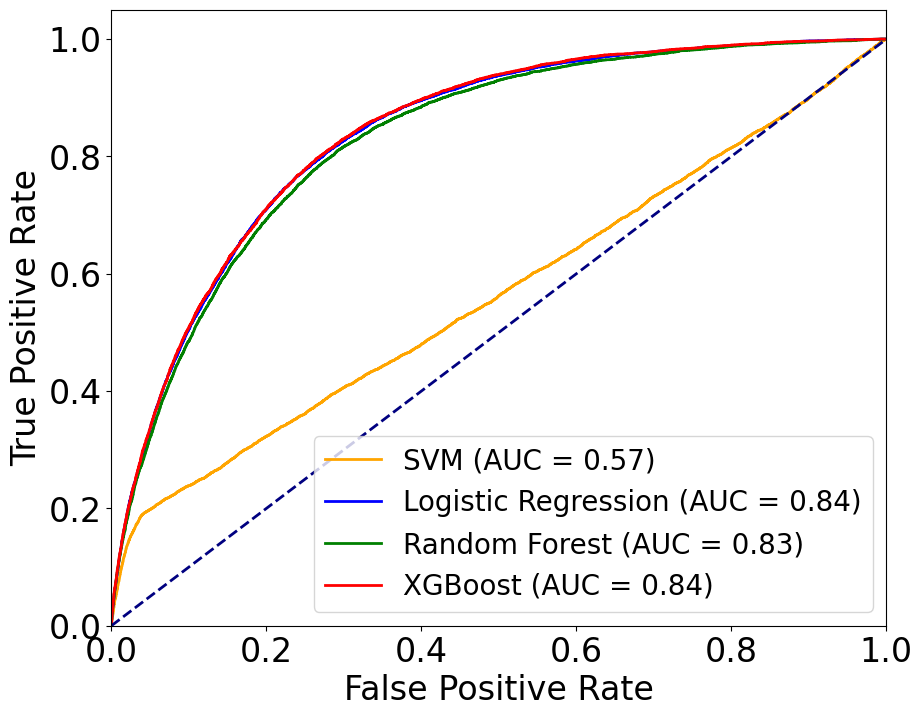

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the False Positive Rate and True Positive Rate for each model
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred_proba[:,1])
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_pred_proba[:,1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba[:,1])

# Calculate the AUC for each model
auc_svm = auc(fpr_svm, tpr_svm)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting
plt.figure(figsize=(10, 8))

plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {auc_xgb:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
# plt.title('Receiver Operating Characteristic', fontsize=24)
plt.legend(loc="lower right", fontsize=20)
# Increasing the font size of the numbers on the axes
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('roc_curve_comparison.png')
plt.show()

In [37]:
pd.set_option('display.max_rows', None)

# Retrieve the logistic regression model from the pipeline
logistic_regression_model = log_reg_best.named_steps['logisticregression']

# Get the coefficients and the intercept
coefficients = logistic_regression_model.coef_[0]
intercept = logistic_regression_model.intercept_[0]

# Create a DataFrame for a more interpretable view
feature_names = X_train.columns
coef_df = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficients'])
coef_df.loc['Intercept'] = intercept

print(coef_df)

                                    Coefficients
BMI                                     0.032783
Smoking                                 0.074180
AlcoholDrinking                        -0.015346
Stroke                                  0.126247
PhysicalHealth                          0.097971
MentalHealth                            0.020179
DiffWalking                             0.091338
Sex                                     0.088909
AgeCategory                             0.827473
Diabetic                                0.169363
PhysicalActivity                       -0.033554
GenHealth                              -0.484503
SleepTime                              -0.071254
Asthma                                  0.045282
KidneyDisease                           0.067746
SkinCancer                              0.021366
Race_Asian                             -0.045144
Race_Black                             -0.033221
Race_Hispanic                          -0.027324
Race_Other          

Let's start by extracting and analyzing the feature importance from the Random Forest and XGBoost models.

In [73]:
import pandas as pd

# Assuming best_rf_model and best_xgb_gpu_model are already defined and trained
# and X_train is your training dataset

# Extracting feature importance
rf_importances = best_rf_model.feature_importances_
xgb_importances = best_xgb_gpu_model.feature_importances_

# Creating a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Random Forest Importance': rf_importances,
    'XGBoost Importance': xgb_importances
})

# Sorting and selecting top 10 features for each model
top_rf_features = feature_importance_df[['Feature', 'Random Forest Importance']] \
                    .sort_values(by='Random Forest Importance', ascending=False).head(10)

top_xgb_features = feature_importance_df[['Feature', 'XGBoost Importance']] \
                    .sort_values(by='XGBoost Importance', ascending=False).head(10)

# Combining the top features from both models for comparison
top_features_combined = pd.concat([top_rf_features, top_xgb_features], axis=1)

top_features_combined


,Feature,Random Forest Importance,Feature,XGBoost Importance
8,AgeCategory,0.119173,AgeCategory,0.064537
11,GenHealth,0.076952,GenHealth,0.060639
9,Diabetic,0.043470,Diabetic,0.031262
27,BMI_x_DiffWalking,0.036114,NaN,NaN
24,BMI_x_Stroke,0.027209,NaN,NaN
75,Stroke_x_SleepTime,0.024004,NaN,NaN
6,DiffWalking,0.023511,DiffWalking,0.057305
30,BMI_x_SleepTime,0.023302,NaN,NaN
113,DiffWalking_x_SleepTime,0.022398,DiffWalking_x_SleepTime,0.035676
28,BMI_x_Sex,0.021737,NaN,NaN


## Appendix: The qustionarie

Feature Selection

0
Race
American Indian/Alaskan Native
Asian
Black
Hispanic
Other
White

Sex
Female
Male

Age category
18-24
25-29
30-34
35-39
40-44
45-49
50-54
55-59
60-64
65-69
70-74
75-79
80 or older

BMI category
Normal weight (18.5 <= BMI < 25.0)
Obese (30.0 <= BMI < +Inf)
Overweight (25.0 <= BMI < 30.0)
Underweight (BMI < 18.5))

How many hours on average do you sleep?
7(continuous)


How can you define your general health?
Excellent
Fair
Good
Poor
Very good

For how many days during the past 30 days was your physical health not good?
0(continuous)


For how many days during the past 30 days was your mental health not good?
0(continuous)


Have you played any sports (running, biking, etc.) in the past month?
No

Have you smoked at least 100 cigarettes in your entire life (approx. 5 packs)?)
No

Do you have more than 14 drinks of alcohol (men) or more than 7 (women) in a week?
No

Did you have a stroke?
No

Do you have serious difficulty walking or climbing stairs?
No

Have you ever had diabetes?
No

Do you have asthma?
No

Do you have kidney disease?
No

Do you have skin cancer?
No
